# Modeling the Perfectly Roasted Marshmallow

Leila Merzenich and Nathan Weil


### What temperature and amount of time will create the perfectly roasted marshmallow?

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# Import functions from the modsim.py module
from modsim import *

# Import numpy
import numpy

To answer this question, we need to see at what temperature and time the core of the marshmallow is roasted thoroughly and the outside is crispy but not burnt. In order to understand the heat transfer process through the marshmallow from the outside air, we separated the marshmallow into three concentric sections with the same masses and varying thicknesses. This simplification is helpful because it is challenging to model the marshmallow as one large flow of energy, and does not over-simplify the heat transfer process.

The energy held in each subsection is a stock, as well as the temperature that the amount of energy creates, because the temperatures and energies all affect each other and need to be calculated over time. The mass of each ring in the marshmallow is the same, and the thickness and surface area were calculated based on that. We used the conductivity of bread as a proxy for that of a marshmallow, which is a big assumption to make but is reasonable given that they are similar consistencies and we could not find the conductivity of a marshmallow, but found a reasonable range of possible values and that of bread fit within our range. We were able to find the specific heat of a marshmallow.

The initial temperature of our marshmallow is 50 degrees fahrenheit or 283 Kelvin, an average temperature for a night camping. Using this we calculated the initial heat energy stored in each layer of the marshmallow below.


In [2]:
# Sets external temperature for example
eTemp=360

# Sets initial temperature and calculates initial energy
initial_temp = 283
initial_energy = initial_temp*(2.33*2.02)

1331.9678

In [3]:
def make_system(eTemp):
    """Makes a system object including all parameters
        
    eTemp: cooking temperature outside of marshmallow
    
    returns: System object
    """
   
    # Initializes state object
    init = State(outer=initial_energy, middle=initial_energy, inner=initial_energy, 
                 oTemp=initial_temp, mTemp=initial_temp, iTemp=initial_temp, o_proportion=0, i_proportion=0)
    
    # Size of the time steps
    dt=10 
    # Thermal conductivity
    conductivity=0.1 
    # Surface are of a marshmallow
    areaOuter=0.004054 
    # Surface area of the middle section of the marshmallow
    areaMiddle=0.003091 
    # Surface are of the inner section
    areaInner=0.001946 
    # Thickness of the outer layer
    thicknessOuter=0.00161 
    # Thickness of the middle layer
    thicknessMiddle=0.00229 
    # Thickness of the inner core
    thicknessInner=0.0088 
    # Each layer has the same mass
    mass=2.33
    # Specific heat capacity of a marshmallow
    specificMarshmallow=2.02 
    # Initial time
    t0=0
    # Ending time in seconds
    t_end=1000 
    # Starting sweep temperature
    start_temp = 350
    # Ending sweep Temperature
    end_temp = 450

    return System(init=init, dt=dt, conductivity=conductivity, 
                  areaOuter=areaOuter, areaMiddle=areaMiddle, 
                  areaInner=areaInner, thicknessOuter=thicknessOuter, 
                  thicknessMiddle=thicknessMiddle, 
                  thicknessInner=thicknessInner, mass=mass, 
                  specificMarshmallow=specificMarshmallow, t0=t0, t_end=t_end,
                  start_temp=start_temp, end_temp=end_temp, eTemp=eTemp)

In order to calculate the heat transfered from the outside air to the marshmallow and from each section to the inner section, we used the following equations:

dQ/dt=(kA(T2-T1))/d

T=Q/mc

Q=heat transfered

k=thermal conductivity

A=surface area

T1=first temp

T2=second temp

d=thickness

m=mass

Cmarshmallow=specific heat

At each step, we will add the energy transfered from the next outer section and subtract the energy transfered to the next inner section using the temperature from the previous time step. The temperature is recalculated at each step using the total energy during that timestep.

In [4]:
def update_func(state, t, system):
    """calculates values and updates state for each time step 
     
    state: State object
    t: current time step
    system: System object
    
    returns: updated State object
    """
    # Initalizes local state
    outer, middle, inner, oTemp, mTemp, iTemp, o_proportion, i_proportion = state
    
    # Unpacks System object
    unpack(system)
    
    # Energy transfered from outside air to outer layer
    dQdt1 = (conductivity*areaOuter*(eTemp-oTemp))/thicknessOuter 
    # From outer to midle layer
    dQdt2 = (conductivity*areaMiddle*(oTemp-mTemp))/thicknessMiddle 
    # Middle to inner layer
    dQdt3 = (conductivity*areaInner*(mTemp-iTemp))/thicknessInner #W/mK*m^2*K/m = W
    
    # Add energy transfered from air and subtract energy lost to middle layer
    outer += (dQdt1 - dQdt2)*dt 
    # Add energy from outer and subtract energy to inner
    middle += (dQdt2 - dQdt3)*dt 
    # Add energy from middle
    inner += (dQdt3)*dt 
    
    # Converts Energy to Temperature
    # Energy/(kg*energy/(kg*K)) = K
    iTemp = inner/(mass*specificMarshmallow) 
    mTemp = middle/(mass*specificMarshmallow)
    oTemp = outer/(mass*specificMarshmallow)
    
    # Calculates temperature as proportion of temperature range
    o_proportion = (oTemp-initial_temp)/(end_temp-initial_temp)
    i_proportion = (iTemp-initial_temp)/(end_temp-initial_temp) 
 
    return State(outer=outer, middle=middle, inner=inner,
                 oTemp=oTemp, mTemp=mTemp, iTemp=iTemp, o_proportion=o_proportion,
                 i_proportion=i_proportion)

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    # Unpacks System object
    unpack(system)
    
    # Initalizes time frame
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    # Runs update function for each time step
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [6]:
def plot_results(oTemp, mTemp, iTemp):
    """Plots results from run_simulation
        
    oTemp: outer temperature of marshmallow
    mTemp: middle temperature of marshmallow
    iTemp: inner temperature of marshmallow
    
    Displays: Plot of marshmallow section temperature over time
    """
    # Plots each temperature curve
    plot(oTemp, '--', label='Outer Temp')
    plot(mTemp, '-', label='Middle Temp')
    plot(iTemp, '-', label='Inner Temp')
    decorate(xlabel='Time (seconds)',
             ylabel='Tempurature(K)',
             title='Temperatures of Marshmallow Zones vs Time')

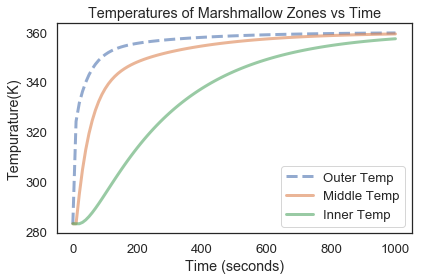

In [7]:
# Makes system and runs simulation
system = make_system(eTemp)
results = run_simulation(system, update_func)

plot_results(results.oTemp, results.mTemp, results.iTemp)

The graph above shows the temperatures of the three subsections of the marshmallow over time, with an external temperature of 360 Kelvin. The conduction of heat through the different layers of the marshmallow is evident by the differing slopes of the three subsections.

In order to show our model’s results in a comprehensible manner, we created a heat map using a sweep of time and external temperature. We wanted to do this with the core temperature as well as the outer temperature to understand at what values of both the marshmallow would be perfect. 

Then, given that the internal temperature must be at least 336 Kelvin and the external temperature cannot exceed 358 Kelvin, we created a ideal heat zone confined by this upper limit of the outer section and this lower limit of the inner section of the marshmallow. 

In [8]:
def sweep_params(system):
    """
    Sweeps external temperature, running simulation each time
    Saves data in arrays for ploting on heat map
        
    system: System object
    
    returns: array of outer results, 
             array of inner results, 
             array of ideal zones
    """
    # Initalizes external temperature sweep values
    sweep_array = linrange(355, 400, .5)

    # Initializes arrays to return
    o_results = []
    i_results = []
    zone = []
    
    # Sweeps external temperature values
    for eTemp in sweep_array:

        # Makes new system with external temperature from sweep
        system = make_system(eTemp)
        
        # Runs simulation for new system
        data = run_simulation(system, update_func)
        
        # Sets step arrays as calculated proportions from run_simulation
        # Negative values to invert heat map colors
        o_step = -data.o_proportion
        i_step = -data.i_proportion
        
        # Initializes zone step array
        zone_step = []
                
        # Sweeps internal and outer temperatures to find perfect range
        for t in linrange(t0, t_end, dt):
            if data.iTemp[t] < 336 and data.oTemp[t] > 358:
                zone_num = .4
            elif data.oTemp[t] > 358:
                zone_num = 0
            elif data.iTemp[t] < 336:
                zone_num = 1
            else:
                zone_num = 0.65
                
            if 335.5 < data.iTemp[t] < 336.5 and 357 < data.oTemp[t] < 358.5:
                print('Ideal Time: ' + str(t))
                print('Ideal External Temperature: ' + str(eTemp))
            # Adds result to zone_step array
            zone_step.append(zone_num)
        
        # Updates all main arrays
        o_results.append(o_step)
        i_results.append(i_step)
        zone.append(zone_step)
        
    return o_results, i_results, zone

In [9]:
def map_values(results, title):
    """ Maps arrays on to heat maps
        
    results: single array of values from sweep_params
    title: title of heat map
    
    Displays: heat map of data stored in results
    """    
    # Labels heat map
    decorate(xlabel='Time (deca-seconds)',
         ylabel='Relative Tempurature',
         title=title)
             
    # Plots heat map
    plt.imshow(results, cmap='hot', interpolation='nearest')
    plt.show()

In [10]:
o_results, i_results, zone = sweep_params(system)

Ideal Time: 390
Ideal External Temperature: 359.5
Ideal Time: 380
Ideal External Temperature: 360.0
Ideal Time: 380
Ideal External Temperature: 360.5


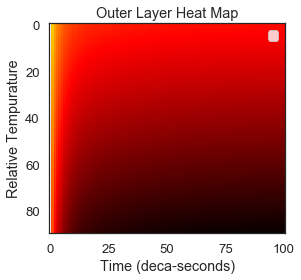

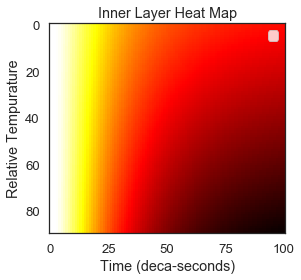

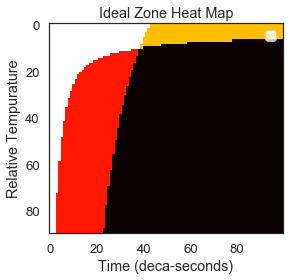

In [11]:
map_values(o_results, 'Outer Layer Heat Map')
map_values(i_results, 'Inner Layer Heat Map')
map_values(zone, 'Ideal Zone Heat Map')

In the graphs above, relative temperature as it appears on the y-axis is temperature in Kelvin from 355 to 400. Each number on the y-axis corresponds to an increase of half a Kelvin. Each number on the x-axis corresponds to ten seconds. Our lowest external temperature is 355 because in order to have the outside of our marshmallow be perfectly crispy it needs to reach at minimum this temperature.

The first graph maps the external temperature, with the lightest color being the initial temperature of the marshmallow at 283 Kelvin and the darkest being 450 Kelvin. The second graph maps the internal temperature on the same scale. The last graph has four sections, undercooked outside and inside (white), burnt outside and undercooked inside (red), burnt outside and well-cooked inside (black), and perfectly cooked outside and in (yellow). 

This graph shows that the easiest way to create the perfect marshmallow is to keep the marshmallow in a temperature within the range of 355-358 for at least 400 seconds. However, in order to maximize time, the marshmallow should be roasted at 360 Kelvin for 380 seconds.



If we were to further prove our model, we should find a more substantial way to validate our findings through further experimentation. However, given the scope of this project, our assumptions and simplifications were reasonable enough that I feel confident in our findings. Another thing that would have improved our results is if we could calculate the conductivity of a marshmallow instead of relying on bread as a proxy.
In creating this model, we spent extensive time iterating on what would be the best way to calculate the energy stored in various parts of the marshmallow, as well as what the various parameters should be until we reached reasonable results.


## Abstract

We created a model to answer the question, “What temperature and amount of time will create the perfectly roasted marshmallow?” and found through a sweep of external temperature the following heat map of what temperature and time roasted will create a marshmallow that is crispy but not burnt and melted all the way through. To maximize time while creating the perfect marshmallow, a marshmallow should be roasted for 380 seconds at 360 degrees Kelvin, or 188.33 degrees Fahrenheit.



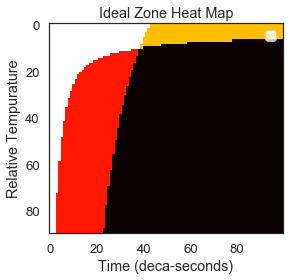

In [12]:
map_values(zone, 'Ideal Zone Heat Map')